# Image captioning with visual attention

In [135]:
import collections
import pathlib
import re
import string

import einops
import matplotlib.pyplot as plt
import numpy as np
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

#### Flickr8k

In [136]:
import shutil
import os
    
def moveFiles(source_dir, target_dir):
    file_names = os.listdir(source_dir)
        
    for file_name in file_names:
        if file_name=='__MACOSX':
            continue
        shutil.move(os.path.join(source_dir, file_name), target_dir)

In [137]:
def flickr8k(path='flickr8k'):
  import shutil
  import os

  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    
    moveFiles(str(path)+'/Flickr8k_Dataset.zip', str(path))
    
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    
    moveFiles(str(path)+'/Flickr8k_text.zip', str(path))

  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

#### Download the dataset

The Flickr8k is a good choice because it contains 5-captions per image, more data for a smaller download.

In [138]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

train_raw, test_raw = flickr8k()

The loaders for both datasets above return `tf.data.Dataset`s containing `(image_path, captions)` pairs. The Flickr8k dataset contains 5 captions per image, while Conceptual Captions has 1:

In [139]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

### Image feature extractor 


In [140]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

In [141]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

### Setup the text tokenizer/vectorizer

In [205]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [206]:
# Use the top 50000 words for a vocabulary.
vocabulary_size = 50000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [207]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [208]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

### Prepare the datasets

In [209]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [210]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


In [211]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

In [212]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [213]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [214]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### Cache the image features

In [215]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [216]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

188it [01:15,  2.48it/s]
32it [00:09,  3.36it/s]


 </section>


## Data ready for training

After those preprocessing steps, here are the datasets:

In [217]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [218]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## A Transformer decoder model

### Input

In [219]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

In [220]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, depth):
    super().__init__()
    self.d_model = depth
    self.embedding = tf.keras.layers.Embedding(vocab_size, depth, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=depth)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

### Decoder

In [221]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


In [222]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [223]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


In [224]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

In [225]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__(**kwargs)
    
    vocab_size = tokenizer.vocabulary_size()
    self.dense = tf.keras.layers.Dense(
        units=vocab_size, **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [226]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:06<00:00, 145.61it/s]



Uniform entropy: 8.94
Marginal entropy: 5.36


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [227]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1, **kwargs):
    super().__init__(**kwargs)
    
    self.max_length = max_length

    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 
    
    self.seq_embedding = PositionalEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [228]:
@Captioner.add_method
def call(self, inputs):
  image, txt = inputs

  if image.shape[-1] == 3:
    # Apply the feature-extractor, if you get an RGB image.
    image = self.feature_extractor(image)
  
  # Flatten the feature map
  image = einops.rearrange(image, 'b h w c -> b (h w) c')


  if txt.dtype == tf.string:
    # Apply the tokenizer if you get string inputs.
    txt = tokenizer(txt)

  txt = self.seq_embedding(txt)

  # Look at the image
  for dec_layer in self.decoder_layers:
    txt = dec_layer(inputs=(image, txt))
    
  txt = self.output_layer(txt)

  return txt

In [266]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, max_length=100, dropout_rate=0.5, num_layers=3, num_heads=4)

### Generate captions

In [267]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

In [268]:
@Captioner.add_method
def simple_gen(self, image, temperature=1, initial_keywords=[]):

  initial = self.word_to_index([['[START]']]) # (batch, sequence)

  initial_keywords = ['[START]'] + initial_keywords
  initial = self.word_to_index([initial_keywords]) # (batch, sequence)

  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)

  for n in range(self.max_length):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)

    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)

    if next[0] == self.word_to_index('[END]'):
      break

  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [269]:
def masked_loss(labels, preds):  
  # print(labels)
  labels = tf.cast(labels, tf.int64)

  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [270]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [271]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=10, restore_best_weights=True)]

### Train

In [272]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [273]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100


/Users/HP/Documents/Documents - Mac/CS 6384 Computer Vision/project-cv/llm-based-VQA-system/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'captioner_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/HP/Documents/Documents - Mac/CS 6384 Computer Vision/project-cv/llm-based-VQA-system/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'causal_self_attention_7' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/HP/Documents/Documents - Mac/CS 6384 Computer Visio

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.6360 - masked_acc: 0.2097



/Users/HP/Documents/Documents - Mac/CS 6384 Computer Vision/project-cv/llm-based-VQA-system/.venv/lib/python3.11/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


a boy in a blue shirt is in a water
a little boy is in a red and white swimsuit
a girl is sitting down the water pool

100/100 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - loss: 4.6321 - masked_acc: 0.2101 - val_loss: 3.7375 - val_masked_acc: 0.3067
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - loss: 3.7146 - masked_acc: 0.3126

a man in a blue shirt is in the water
a young boy wearing a blue pants is jumping into a wave
dogs playfully in the pool

100/100 ━━━━━━━━━━━━━━━━━━━━ 97s 976ms/step - loss: 3.7139 - masked_acc: 0.3127 - val_loss: 3.5811 - val_masked_acc: 0.3264
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - loss: 3.4997 - masked_acc: 0.3376

a man in a blue shirt is in the water
a man in a blue wetsuit on the water
a man and the man wearing a yellow and standing on a pool

100/100 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 3.4996 - masked_acc: 0.3377 - val_loss: 3.4810 - val_masked_acc: 0.3458
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - loss: 3.3901 - m

Plot the loss and accuracy over the training run:

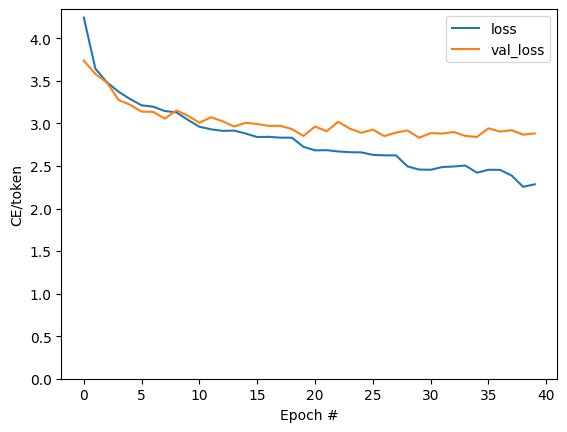

In [274]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

plt.savefig("loss.pdf", bbox_inches='tight')

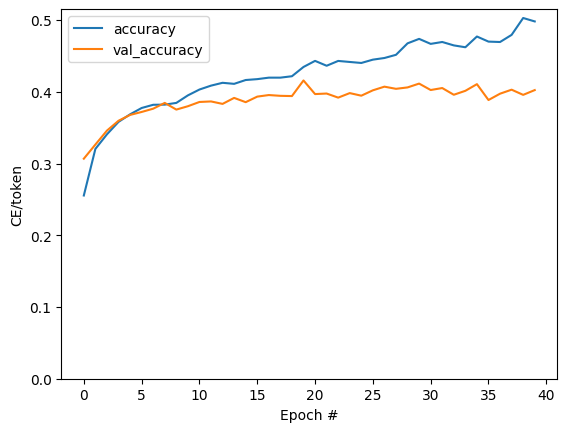

In [275]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

plt.savefig("acc.pdf", bbox_inches='tight')

### Evaluation

In [276]:
import os
import zipfile
import urllib.request
import json
import numpy as np
import pandas as pd
from PIL import Image
import spacy
nlp = spacy.load("en_core_web_sm")

import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# from rouge_score import rouge_scorer
from rouge_score.rouge_scorer import RougeScorer
from bert_score import score as bert_score

In [ ]:
## Downloading dataset for evaluation

def download_file(url, save_path):
    if not os.path.exists(save_path):
        print(f"Downloading: {url}")
        urllib.request.urlretrieve(url, save_path)
        print(f"Saved to: {save_path}")
    else:
        print(f"Already downloaded: {save_path}")

# === Create download directory
os.makedirs("downloads", exist_ok=True)

# === Download URLs
downloads = {
    "val2014.zip": "http://images.cocodataset.org/zips/val2014.zip",
    "annotations_trainval2014.zip": "http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
    "v2_Questions_Val_mscoco.zip": "https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip",
    "v2_Annotations_Val_mscoco.zip": "https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip",
}

# === Download files
for filename, url in downloads.items():
    download_file(url, f"downloads/{filename}")

# === Unzip files
unzip_targets = {
    "downloads/val2014.zip": "val2014",
    "downloads/annotations_trainval2014.zip": "annotations",
    "downloads/v2_Questions_Val_mscoco.zip": "vqa_questions",
    "downloads/v2_Annotations_Val_mscoco.zip": "vqa_annotations",
}

for zip_path, extract_to in unzip_targets.items():
    if not os.path.exists(extract_to):
        print(f"Unzipping {zip_path} to {extract_to}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Extracted to {extract_to}/")
    else:
        print(f"Already extracted: {extract_to}/")

In [277]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
flan_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
flan_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

In [278]:
COCO_PATH = "val2014"
N = 500  # Change to None for full run
IMAGE_SIZE = (224, 224)

In [279]:
# Load VQA questions + answers
with open("vqa_questions/v2_OpenEnded_mscoco_val2014_questions.json") as f:
    questions = json.load(f)["questions"]

with open("vqa_annotations/v2_mscoco_val2014_annotations.json") as f:
    annotations = json.load(f)["annotations"]

answers_map = {ann["question_id"]: ann["answers"] for ann in annotations}
vqa = []
for q in questions:
    if q["question_id"] in answers_map:
        vqa.append({
            "image_id": q["image_id"],
            "question": q["question"],
            "answers": answers_map[q["question_id"]]
        })

In [280]:
rouge = RougeScorer(["rougeL"], use_stemmer=True)
smoother = SmoothingFunction().method1

In [281]:
bleu_vals, rouge_vals = [], []
bert_preds = []
bert_refs = []
output_log = []

In [282]:
def rearrange_question(question):
    doc = nlp(question)

    rearranged = []
    root = None
    root_pos = -1
    count = 0
    root_added = False
    for token in doc:

        # print(token.text, token.pos_)

        if root_pos==-1 and token.pos_ == 'AUX':
            if count == 0:
                return[]
            root = token
            root_pos = count

        elif root_pos!=-1 and token.pos_ != 'PUNCT':

            if token.pos_ == 'VERB':
                root_added = True
                rearranged.append(root)
            rearranged.append(token)

        count += 1

    if not root_added and root:
        rearranged.append(root)

    # if rearranged[-1].pos_ == 'VERB':
    #     rearranged.insert(len(rearranged)-1, root)
    # else:
    #     rearranged.insert(len(rearranged), root)
        
    rearranged_str = [text.text.lower() for text in rearranged]

    if root_pos == 2:
        rearranged_str.insert(0, doc[1].text)
        rearranged_str.insert(1, "of")

    if doc[0].text == 'Why':
        rearranged_str.append('because')
    return rearranged_str



In [283]:
def load_and_preprocess(img_path):
    img = Image.open(img_path).convert("RGB").resize(IMAGE_SIZE)
    arr = np.asarray(img).astype("float32")
    return arr

def answer_question_from_captions(captions, question):
    prompt = f"Given the following descriptions:\n{' '.join(captions)}\nAnswer the question: {question}. Donot hallucinate. Provide short answer."
    inputs = flan_tokenizer(prompt, return_tensors="pt", truncation=True)
    outputs = flan_model.generate(**inputs, max_length=40)
    return flan_tokenizer.decode(outputs[0], skip_special_tokens=True)

In [263]:
img_path = os.path.join(COCO_PATH, f"COCO_val2014_{vqa[480]['image_id']:012d}.jpg")
image = load_image(img_path)

im=Image.open(img_path)
im.show()
image.shape

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TensorShape([224, 224, 3])

In [264]:
model.simple_gen(image, temperature=0.0, initial_keywords=[])

/Users/HP/Documents/Documents - Mac/CS 6384 Computer Vision/project-cv/llm-based-VQA-system/.venv/lib/python3.11/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/Users/HP/Documents/Documents - Mac/CS 6384 Computer Vision/project-cv/llm-based-VQA-system/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'causal_self_attention_2' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/HP/Documents/Documents - Mac/CS 6384 Computer Vision/project-cv/llm-based-VQA-system/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:940: Us

'a white and white dog is in the air'

In [284]:
print(f"Evaluating {N or len(vqa)} examples...\n")
count = 0
for example in tqdm.tqdm(vqa[:N]):
    try:
        img_id = int(example["image_id"])
        img_path = os.path.join(COCO_PATH, f"COCO_val2014_{img_id:012d}.jpg")

        image_tensor = load_and_preprocess(img_path)
        keywords = rearrange_question(example["question"])
        caption = model.simple_gen(image_tensor, temperature=0.0, initial_keywords=keywords)

        prediction = answer_question_from_captions([caption], example["question"])
        references = [a["answer"].lower() for a in example["answers"]]

        # BLEU & ROUGE
        bleu = max(sentence_bleu([r.split()], prediction.split(), smoothing_function=smoother) for r in references)
        rouge_l = max(rouge.score(prediction, ref)["rougeL"].fmeasure for ref in references)

        bleu_vals.append(bleu)
        rouge_vals.append(rouge_l)
        bert_preds.append(prediction)
        bert_refs.append(references[0])

        # Log sample
        if len(bleu_vals) % 10 == 1:
            print(count)
            print(f"\nQ: {example['question']}\nKeywords: {keywords}\nCaption: {caption}\nPrediction: {prediction}\nGT: {references[0]}\n")

        output_log.append({
            "image_id": img_id,
            "question": example["question"],
            "caption": caption,
            "prediction": prediction,
            "ground_truth": references
        })

    except Exception as e:
        print(example["question"])
        print(f"Error at {img_id}: {e}")
        continue

    count += 1

Evaluating 500 examples...



  0%|          | 0/500 [00:00<?, ?it/s]/Users/HP/Documents/Documents - Mac/CS 6384 Computer Vision/project-cv/llm-based-VQA-system/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'causal_self_attention_7' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/HP/Documents/Documents - Mac/CS 6384 Computer Vision/project-cv/llm-based-VQA-system/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'decoder_layer_7' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
  0%|          | 1/500 [00:10<1:27:29, 10.52s/it]

0

Q: Where is he looking?
Keywords: ['he', 'is', 'looking']
Caption: he is looking at a man in a black shirt
Prediction: at a man in a black shirt
GT: down



  1%|          | 3/500 [00:11<21:59,  2.66s/it]  /Users/HP/Documents/Documents - Mac/CS 6384 Computer Vision/project-cv/llm-based-VQA-system/.venv/lib/python3.11/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
  2%|▏         | 11/500 [00:14<03:49,  2.13it/s]

10

Q: Why is there a gap between the roof and wall?
Keywords: ['there', 'a', 'gap', 'between', 'the', 'roof', 'and', 'wall', 'is', 'because']
Caption: there a gap between the roof and wall is because
Prediction: Do not hallucinate
GT: ventilation



  4%|▍         | 21/500 [00:19<03:38,  2.19it/s]

20

Q: What color is the bedspread?
Keywords: ['color', 'of', 'the', 'bedspread', 'is']
Caption: color of the bedspread is laying on a bed
Prediction: hallucinate
GT: beige



  6%|▌         | 31/500 [00:23<03:16,  2.39it/s]

30

Q: Is the bed white?
Keywords: []
Caption: a man is sitting on a bed with a large blue blanket
Prediction: no
GT: yes



  8%|▊         | 41/500 [00:28<03:35,  2.13it/s]

40

Q: How many frames are on the wall?
Keywords: ['on', 'the', 'wall', 'are']
Caption: on the wall are sitting on a bed
Prediction: two
GT: 7



 10%|█         | 51/500 [00:32<03:27,  2.17it/s]

50

Q: Is this person wearing a tie?
Keywords: []
Caption: a young boy is eating a small child with a red shirt
Prediction: Yes
GT: no



 12%|█▏        | 61/500 [00:37<03:20,  2.19it/s]

60

Q: What kind of vehicle is the RV pulling on the bottom picture?
Keywords: ['the', 'rv', 'is', 'pulling', 'on', 'the', 'bottom', 'picture']
Caption: the rv is pulling on the bottom picture of a car
Prediction: car
GT: jeep



 14%|█▍        | 71/500 [00:42<03:23,  2.11it/s]

70

Q: What does the last sign say?
Keywords: ['the', 'last', 'sign', 'does', 'say']
Caption: the last sign does say on the train
Prediction: Do not hallucinate
GT: ross st



 16%|█▌        | 81/500 [00:46<03:09,  2.22it/s]

80

Q: Is there a tree in front of the building?
Keywords: []
Caption: a man is standing on a street with a large building in the background
Prediction: Yes
GT: yes



 18%|█▊        | 91/500 [00:51<03:14,  2.10it/s]

90

Q: Is it still snowing in the picture?
Keywords: []
Caption: a man is walking through the snow
Prediction: no
GT: yes



 20%|██        | 101/500 [01:03<03:33,  1.87it/s]

100

Q: What is the background metal structure?
Keywords: ['the', 'background', 'metal', 'structure', 'is']
Caption: the background metal structure is walking down the road
Prediction: a human
GT: trees



 22%|██▏       | 111/500 [01:08<03:01,  2.14it/s]

110

Q: What year is the car?
Keywords: ['year', 'of', 'the', 'car', 'is']
Caption: year of the car is standing on the street
Prediction: a year
GT: 2014



 24%|██▍       | 121/500 [01:13<04:14,  1.49it/s]

120

Q: Is that a cake?
Keywords: []
Caption: a man in a red shirt and a black shirt is standing on a city street
Prediction: No
GT: no



 26%|██▌       | 131/500 [01:19<03:32,  1.74it/s]

130

Q: Will these giraffes be eating the grass for dinner?
Keywords: []
Caption: a man in a brown shirt is riding a bike on a sandy beach
Prediction: No
GT: yes



 28%|██▊       | 141/500 [01:24<02:23,  2.50it/s]

140

Q: Is this man snowboarding?
Keywords: []
Caption: a snowboarder in the air
Prediction: Yes
GT: yes



 30%|███       | 151/500 [01:27<02:03,  2.82it/s]

150

Q: Does the man have goggles on?
Keywords: []
Caption: a snowboarder in the air
Prediction: Yes
GT: yes



 32%|███▏      | 161/500 [01:31<02:17,  2.46it/s]

160

Q: Does this dog have a collar?
Keywords: []
Caption: a young boy is playing with a dog on a leash
Prediction: Yes
GT: yes



 34%|███▍      | 171/500 [01:36<02:38,  2.08it/s]

170

Q: What color is the ribbon?
Keywords: ['color', 'of', 'the', 'ribbon', 'is']
Caption: color of the ribbon is sitting in a window
Prediction: color
GT: green



 36%|███▌      | 181/500 [01:46<02:46,  1.91it/s]

180

Q: How many babies are there?
Keywords: ['there', 'are']
Caption: there are two men and a woman are playing soccer
Prediction: two
GT: 0



 38%|███▊      | 191/500 [01:50<02:05,  2.46it/s]

190

Q: What does the woman have around her neck?
Keywords: ['the', 'woman', 'does', 'have', 'around', 'her', 'neck']
Caption: the woman does have around her neck
Prediction: a ring
GT: necklace



 40%|████      | 201/500 [01:55<02:06,  2.37it/s]

200

Q: What color is the court?
Keywords: ['color', 'of', 'the', 'court', 'is']
Caption: color of the court is running on the court
Prediction: hallucinate
GT: green



 42%|████▏     | 211/500 [01:59<02:15,  2.13it/s]

210

Q: Is the silver bike new?
Keywords: []
Caption: a man in a red helmet is riding a motorcycle on a dirt bike
Prediction: No
GT: no



 44%|████▍     | 221/500 [02:04<02:06,  2.20it/s]

220

Q: What color is the bike?
Keywords: ['color', 'of', 'the', 'bike', 'is']
Caption: color of the bike is driving a green motorcycle
Prediction: green
GT: white and green



 46%|████▌     | 231/500 [02:08<02:08,  2.10it/s]

230

Q: What color is the fridge?
Keywords: ['color', 'of', 'the', 'fridge', 'is']
Caption: color of the [UNK] is looking at the window
Prediction: unanswerable
GT: gray or silver



 48%|████▊     | 241/500 [02:14<02:39,  1.63it/s]

240

Q: What is written on the surfboard?
Keywords: ['is', 'written', 'on', 'the', 'surfboard']
Caption: is written on the surfboard on top of a snowy mountain
Prediction: Do not hallucinate
GT: lifeguard



 50%|█████     | 251/500 [02:19<02:09,  1.92it/s]

250

Q: Is this an English saddle?
Keywords: []
Caption: a woman in a pink shirt is holding a guitar
Prediction: no
GT: yes



 52%|█████▏    | 261/500 [02:24<01:35,  2.50it/s]

260

Q: What kind of birds are these?
Keywords: ['these', 'are']
Caption: these are flying over the beach
Prediction: birds
GT: herons



 54%|█████▍    | 271/500 [02:28<01:50,  2.07it/s]

270

Q: How many sets of doors are open?
Keywords: ['open', 'are']
Caption: open are standing on a train
Prediction: two sets
GT: 1



 56%|█████▌    | 281/500 [02:35<03:00,  1.21it/s]

280

Q: Is there a woman sitting on this bench??
Keywords: []
Caption: a woman in a black shirt and a woman in a black shirt and a black shirt and a woman are walking on the sidewalk
Prediction: no
GT: yes



 58%|█████▊    | 291/500 [02:46<03:15,  1.07it/s]

290

Q: Is the girl smiling?
Keywords: []
Caption: a man in a black hat and a woman in a black shirt and a black hat
Prediction: No
GT: no



 60%|██████    | 301/500 [02:55<02:59,  1.11it/s]

300

Q: What about this man's appearance might bother a conservative employer?
Keywords: ['might', 'bother', 'a', 'conservative', 'employer']
Caption: [UNK] [UNK] a [UNK] [UNK]
Prediction: a
GT: yes



 62%|██████▏   | 311/500 [03:08<03:19,  1.06s/it]

310

Q: Where are the ducks?
Keywords: ['the', 'ducks', 'are']
Caption: the ducks are walking down the street
Prediction: street
GT: can't see



 64%|██████▍   | 321/500 [03:17<02:41,  1.11it/s]

320

Q: Is this a tour bus?
Keywords: []
Caption: a man is riding a skateboard on a street
Prediction: No
GT: yes



 66%|██████▌   | 331/500 [03:26<02:24,  1.17it/s]

330

Q: What color is the camper?
Keywords: ['color', 'of', 'the', 'camper', 'is']
Caption: color of the camper is walking down the street
Prediction: hallucinate
GT: white



 68%|██████▊   | 341/500 [03:35<02:11,  1.21it/s]

340

Q: Is the person on the laptop married?
Keywords: []
Caption: a man is sitting on a table with his hand
Prediction: no
GT: yes



 70%|███████   | 351/500 [03:43<01:44,  1.43it/s]

350

Q: Is the giraffes head small?
Keywords: []
Caption: a dog is jumping over a wooden fence
Prediction: no
GT: yes



 72%|███████▏  | 361/500 [03:51<01:45,  1.32it/s]

360

Q: Is the catcher wearing safety gear?
Keywords: []
Caption: a boy in a blue shirt is running on a field
Prediction: No
GT: yes



 74%|███████▍  | 371/500 [03:56<01:05,  1.96it/s]

370

Q: What is the color of the sky?
Keywords: ['the', 'color', 'of', 'the', 'sky', 'is']
Caption: the color of the sky is flying through the air
Prediction: hallucinate
GT: blue



 76%|███████▌  | 381/500 [04:04<01:34,  1.26it/s]

380

Q: Is this going to be a feast?
Keywords: []
Caption: a woman is sitting in a chair with a baby in a chair
Prediction: No
GT: yes



 78%|███████▊  | 391/500 [04:10<01:01,  1.77it/s]

390

Q: What type of food is being sold?
Keywords: ['being', 'is', 'sold']
Caption: being is [UNK] of people in a restaurant
Prediction: food
GT: pastries



 80%|████████  | 401/500 [04:17<00:54,  1.83it/s]

400

Q: What is the large figure?
Keywords: ['the', 'large', 'figure', 'is']
Caption: the large figure is walking on the beach
Prediction: a human
GT: two giraffe



 82%|████████▏ | 411/500 [04:23<00:50,  1.76it/s]

410

Q: Do the people know each other?
Keywords: []
Caption: two children are sitting on a couch
Prediction: no
GT: yes



 84%|████████▍ | 421/500 [04:30<00:54,  1.45it/s]

420

Q: Is this a glass flower vase?
Keywords: []
Caption: a man in a red shirt is standing on a table with a red and white bike
Prediction: No
GT: yes



 86%|████████▌ | 431/500 [04:37<00:41,  1.65it/s]

430

Q: Is the train in the city?
Keywords: []
Caption: a person is walking down a road
Prediction: No
GT: no



 88%|████████▊ | 441/500 [04:43<00:27,  2.18it/s]

440

Q: What is the cat looking at?
Keywords: ['the', 'cat', 'is', 'looking', 'at']
Caption: the cat is looking at the camera
Prediction: camera
GT: camera



 90%|█████████ | 451/500 [04:49<00:25,  1.91it/s]

450

Q: How many rolls of toilet paper are there?
Keywords: ['there', 'are']
Caption: there are two people sitting on a blue blanket
Prediction: None
GT: 1



 92%|█████████▏| 461/500 [04:54<00:21,  1.77it/s]

460

Q: How many cats?
Keywords: []
Caption: a person is sitting on a blue blanket
Prediction: a single cat
GT: 0



 94%|█████████▍| 471/500 [05:00<00:16,  1.77it/s]

470

Q: Does this toilet have a lit?
Keywords: []
Caption: a person is sitting on a blue blanket
Prediction: no
GT: yes



 96%|█████████▌| 481/500 [05:07<00:11,  1.59it/s]

480

Q: Is the bathroom clean?
Keywords: []
Caption: a person is sitting on a blue blanket
Prediction: no
GT: yes



 98%|█████████▊| 491/500 [05:12<00:04,  2.09it/s]

490

Q: What is the metal rack on the wall for?
Keywords: ['the', 'metal', 'rack', 'on', 'the', 'wall', 'for', 'is']
Caption: the metal rack on the wall for is looking at the camera
Prediction: a camera
GT: toilet paper holder



100%|██████████| 500/500 [05:17<00:00,  1.57it/s]


In [285]:
# BERTScore
_, _, bert_f1 = bert_score(bert_preds, bert_refs, lang="en", model_type="bert-base-uncased")

In [286]:
# Final results
print("\n────────── RESULTS ──────────")
print(f"Avg BLEU-4   : {np.mean(bleu_vals):.4f}")
print(f"Avg ROUGE-L  : {np.mean(rouge_vals):.4f}")
print(f"Avg BERTScore: {bert_f1.mean().item():.4f}")


────────── RESULTS ──────────
Avg BLEU-4   : 0.0305
Avg ROUGE-L  : 0.3606
Avg BERTScore: 0.6765


In [287]:
# Save CSV
df = pd.DataFrame(output_log)
df.to_csv("vqa_eval_results.csv", index=False)
print("\nSaved results to 'vqa_eval_results.csv'")


Saved results to 'vqa_eval_results.csv'
